Classification with PLS-DA
===

Author: Nathan A. Mahynski

Date: 2023/08/23

Description: Illustrate modeling with PLS-DA.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mahynski/pychemauth/blob/main/docs/jupyter/api/plsda.ipynb)

In [ ]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/mahynski/pychemauth@main
    import os
    os.kill(os.getpid(), 9) # Automatically restart the runtime to reload libraries

In [1]:
try:
    import pychemauth
except:
    raise ImportError("pychemauth not installed")

import matplotlib.pyplot as plt
%matplotlib inline

import watermark
%load_ext watermark

%load_ext autoreload
%autoreload 2

In [2]:
import imblearn
import sklearn

from sklearn.model_selection import GridSearchCV

import numpy as np
import pandas as pd

In [3]:
%watermark -t -m -v --iversions

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 7.34.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.1.85+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

pychemauth: 0.0.0b4
sklearn   : 1.3.0
matplotlib: 3.7.2
pandas    : 1.5.3
watermark : 2.4.3
imblearn  : 0.11.0
numpy     : 1.24.3



<h3>Load the Data</h3>

In [4]:
from sklearn.datasets import load_iris as load_data
X, y = load_data(return_X_y=True, as_frame=True)

In [5]:
# Let's turn the indices into names
names = dict(zip(np.arange(3), ['setosa', 'versicolor', 'virginica']))
y = y.apply(lambda x: names[x])

In [6]:
X.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X.values,
    y.values,
    shuffle=True,
    random_state=42,
    test_size=0.2,
    stratify=y # It is usually important to balance the test and train set so they have the same fraction of classes
)

Fitting a PLS-DA Model
---

In [8]:
from pychemauth.classifier.plsda import PLSDA

<h3>Training a Hard Model</h3>

"Hard" PLS-DA models use hyperplanes to divide the latent (score) space into distinct regions, 1 and only 1 of which is associated with a class.


In [9]:
hard_plsda = PLSDA(
    n_components=3,
    alpha=0.05,
    gamma=0.01,
    not_assigned='UNKNOWN', # This needs to match the same datatype as y (here, y is str); for integers, e.g., use -1
    style="hard",
    scale_x=True,
    score_metric='TEFF' # Let's use TEFF as the model's scoring metric.  This could be TSNS or TSPS instead.
)

In [10]:
_ = hard_plsda.fit(X_train, y_train)

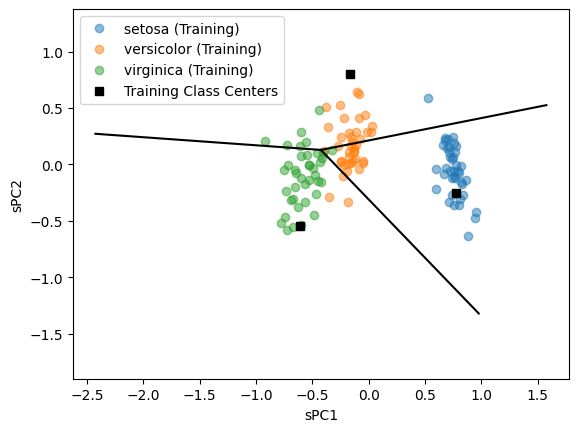

In [11]:
# 3 class systems can be plotted in 2D, 2 class systems in 1D; more than 3 cannot be shown. `visualize` automatically
# selects the right version for your.
_ = hard_plsda.visualize(styles=['hard'])

In [12]:
# We can see what samples are predicted to be using the predict() function.
pred = hard_plsda.predict(X_train)

In [13]:
print(
    'Test set TEFF = {}\nTrain set TEFF = {}'.format(
        '%.3f'%hard_plsda.score(X_test, y_test),
        '%.3f'%hard_plsda.score(X_train, y_train)
    )
)

Test set TEFF = 0.733
Train set TEFF = 0.750


For Hard PLS-DA each point is predicted to belong to 1 and only 1 class, so TEFF = TSPS = TSNS


In [14]:
# The score() function is just testing how many are correctly predicted.  You can do this directly and
# easily with the "hard" version of PLS-DA.
fom = hard_plsda.figures_of_merit(pred, y_train)

print(fom['TSNS'], fom['TSPS'], fom['TEFF'])

0.75 0.75 0.75


In [15]:
# This is also equivalent to the accuracy of the model
np.sum(np.array(pred).ravel() == y_train) / y_train.shape[0]

0.75

In [16]:
# Each row is what the sample ACTUALLY is, each column is what the PREDICTION is.
# Here, versicolor is predicted to be setosa 19 times.

fom['CM']

,setosa,versicolor,virginica,UNKNOWN
setosa,39,1,0,0
versicolor,19,18,3,0
virginica,1,6,33,0


In [17]:
# Total for each category
fom['I']

setosa        40
versicolor    40
virginica     40
dtype: int64

In [18]:
# Class sensitivity
fom['CSNS']

setosa        0.975
versicolor    0.450
virginica     0.825
dtype: float64

In [19]:
# Class specificity
fom['CSPS']

setosa        0.7500
versicolor    0.9125
virginica     0.9625
dtype: float64

In [20]:
# Class efficiency
fom['CEFF']

setosa        0.855132
versicolor    0.640800
virginica     0.891102
dtype: float64

<h3>Training a Soft Model</h3>

"Soft" PLS-DA models use ellipses to divide the latent (score) space into possibly overlapping regions, meaning that a point can be assigned to 0, 1, or > 1 classes.


In [21]:
# Here the data are elemental levels so we will scale the X data
soft_plsda = PLSDA(
    n_components=3,
    alpha=0.05,
    gamma=0.01,
    not_assigned='UNKNOWN',
    style="soft",
    scale_x=True,
    score_metric='TEFF'
)

In [22]:
_ = soft_plsda.fit(X_train, y_train)

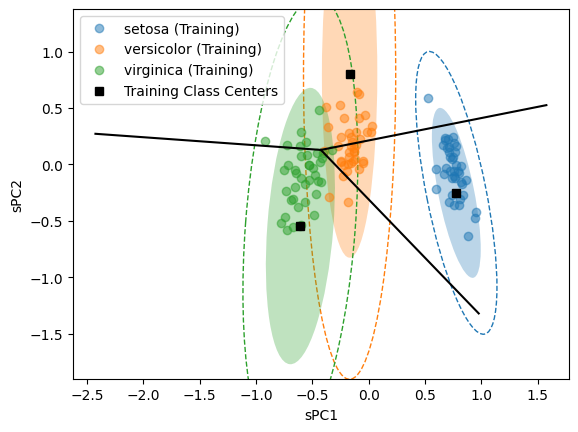

In [27]:
# You can visualize both the hard and soft boundaries if you train a soft model.
# With a hard model, you only get the hard boundaries by default.
_ = soft_plsda.visualize(styles=['hard', 'soft'])

In [28]:
# We can see what samples are predicted to be using the predict() function.
train_pred = soft_plsda.predict(X_train)

In [29]:
# As shown above, there are no outliers in the training data.

# Only the soft version of PLSDA can do this check.
soft_plsda.check_outliers().any()

False

In [30]:
print(
    'Test set TEFF = {}\nTrain set TEFF = {}'.format(
        '%.3f'%soft_plsda.score(X_test, y_test),
        '%.3f'%soft_plsda.score(X_train, y_train)
    )
)

Test set TEFF = 0.983
Train set TEFF = 0.975


In [31]:
# Samples can now be predicted to belong to multiple classes.
train_pred[:10]

[['setosa'],
 ['virginica'],
 ['versicolor'],
 ['setosa'],
 ['versicolor'],
 ['virginica'],
 ['versicolor'],
 ['versicolor', 'virginica'],
 ['virginica'],
 ['virginica']]

In [32]:
# More complete figures of merit can be computed.
fom = soft_plsda.figures_of_merit(train_pred, y_train)

# For Soft PLS-DA TEFF, TSPS, and TSNS are generally different
print(fom['TSNS'], fom['TSPS'], fom['TEFF'])

0.9666666666666667 0.9833333333333333 0.9749643868139777


In [33]:
fom['I']

setosa        40
versicolor    40
virginica     40
dtype: int64

In [34]:
# The soft model can predict that things are unknown and that they might belong to multiple classes.
# Observe that there of 40 versicolor samples, there are 40 assignments to versicolor and 4 to virginica (40 + 4 > 40),
# because some are assigned to both categories.

fom['CM']

,setosa,versicolor,virginica,UNKNOWN
setosa,38,0,0,2
versicolor,0,39,3,0
virginica,0,1,39,1


In [35]:
fom = soft_plsda.figures_of_merit(soft_plsda.predict(X_test), y_test)
fom['CM']

,setosa,versicolor,virginica,UNKNOWN
setosa,10,0,0,0
versicolor,0,10,1,0
virginica,0,1,10,0


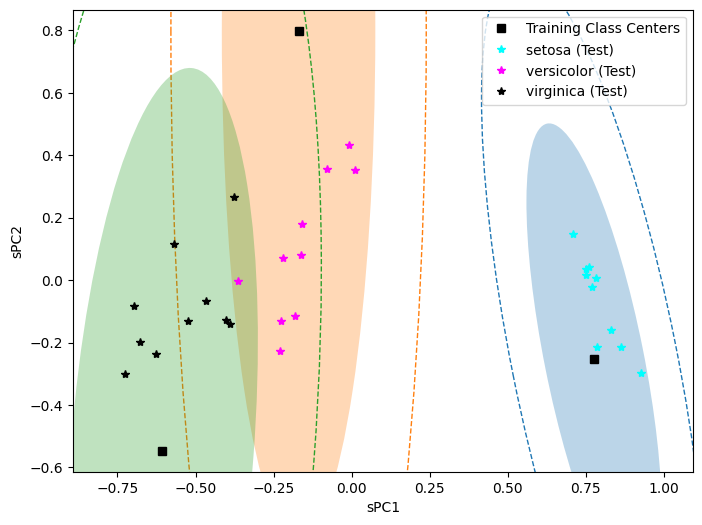

In [38]:
# We can plot the test on the training set like this
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
ax = soft_plsda.visualize(styles=['soft'], ax=ax, show_training=False)

test_set_proj = soft_plsda.transform(X_test)
for color_, class_ in zip(['cyan', 'magenta', 'black'], names.values()):
    mask = y_test == class_
    ax.plot(test_set_proj[mask,0], test_set_proj[mask,1], '*', color=color_, label='{} (Test)'.format(class_))
ax.legend(loc='best')

Optimizing the Model
---

Here we took alpha as a meaningful choice of type I error rate, but it could also be adjusted.  Moreover, we arbitrarily selected the number of PCs to use in the PLSDA model.  We can use scikit-learn's pipelines to automatically optimize hyperparameters like this.


In [39]:
pipeline = imblearn.pipeline.Pipeline(
    steps=[
        ("plsda", PLSDA(
            n_components=5,
            alpha=0.05,
            scale_x=True,
            not_assigned='UNKNOWN',
            style='soft',
            score_metric='TEFF'
        )
    )
])

# Let's optimize the TEFF of the model and allow alpha to vary - this is a "compliant" approach.
param_grid = [{
    'plsda__n_components':[3, 4],
    'plsda__alpha': [0.07, 0.05, 0.03, 0.01],
}]

gs = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    n_jobs=-1,
    cv=sklearn.model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=0),
    error_score=0,
    refit=True
)

_ = gs.fit(X_train, y_train)

In [40]:
# The best parameters found can be accessed like this:
gs.best_params_

{'plsda__alpha': 0.03, 'plsda__n_components': 3}

In [41]:
gs.best_score_ # The best score (TEFF) it recieved was...

0.9727739913024074

In [42]:
# You can see detailed CV results here
gs.cv_results_

{'mean_fit_time': array([0.01206279, 0.01201566, 0.01257658, 0.01141119, 0.01039139,
        0.00962798, 0.00946887, 0.01093936]),
 'std_fit_time': array([0.00088673, 0.00081104, 0.00274705, 0.00102592, 0.00011664,
        0.00012437, 0.0001569 , 0.00038004]),
 'mean_score_time': array([0.02674349, 0.02722987, 0.02487612, 0.02466146, 0.02466027,
        0.02299309, 0.02398237, 0.02348137]),
 'std_score_time': array([0.00175109, 0.00115925, 0.00034594, 0.00036911, 0.00122064,
        0.00117518, 0.00139078, 0.00226715]),
 'param_plsda__alpha': masked_array(data=[0.07, 0.07, 0.05, 0.05, 0.03, 0.03, 0.01, 0.01],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_plsda__n_components': masked_array(data=[3, 4, 3, 4, 3, 4, 3, 4],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'plsda__alpha': 0.07, 'plsda__n_compon

In [43]:
# The refit=True (default) refits the model with best parameters on the entire training set at the end so you can
# use the pipeline directly.
gs.predict(X_test)[:10]

[['setosa'],
 ['virginica'],
 ['versicolor'],
 ['versicolor'],
 ['setosa'],
 ['versicolor'],
 ['setosa'],
 ['setosa'],
 ['virginica'],
 ['versicolor']]

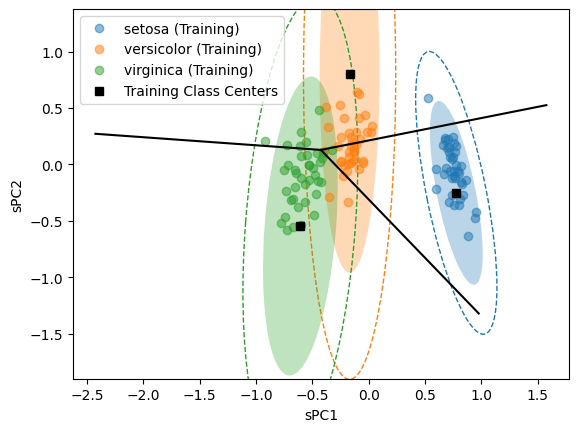

In [44]:
# Within the pipeline you can access individual steps, and their methods.
_ = gs.best_estimator_.named_steps['plsda'].visualize(styles=['hard', 'soft'])

In [45]:
gs.best_estimator_.named_steps['plsda'].score(X_train, y_train) # This is TEFF

0.9791578013783069

In [46]:
train_pred = gs.best_estimator_.named_steps['plsda'].predict(X_train)
fom = gs.best_estimator_.named_steps['plsda'].figures_of_merit(train_pred, y_train)

In [47]:
fom['CM']

,setosa,versicolor,virginica,UNKNOWN
setosa,39,0,0,1
versicolor,0,40,4,0
virginica,0,2,39,1


In [48]:
fom['I']

setosa        40
versicolor    40
virginica     40
dtype: int64

In [49]:
fom['CSNS']

setosa        0.975
versicolor    1.000
virginica     0.975
dtype: float64

In [50]:
fom['CSPS']

setosa        1.000
versicolor    0.975
virginica     0.950
dtype: float64

In [51]:
fom['CEFF']

setosa        0.987421
versicolor    0.987421
virginica     0.962419
dtype: float64

In [52]:
fom['TSPS'], fom['TSNS'], fom['TEFF']

(0.975, 0.9833333333333333, 0.9791578013783069)

In [53]:
np.any(gs.best_estimator_.named_steps['plsda'].check_outliers())

False

In [54]:
# Test set performance
gs.best_estimator_.named_steps['plsda'].score(X_test, y_test) # The score being used here is TEFF

0.9746794344808963

In [55]:
test_pred = gs.best_estimator_.named_steps['plsda'].predict(X_test)
fom = gs.best_estimator_.named_steps['plsda'].figures_of_merit(test_pred, y_test)

In [56]:
fom['CM']

,setosa,versicolor,virginica,UNKNOWN
setosa,10,0,0,0
versicolor,0,10,1,0
virginica,0,2,10,0
